# Project: Wrangling and Analyze Data

In [1]:
#Import libraries needed
import os
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import re
import time
import seaborn as sns
%matplotlib inline

# Change the settings to show all the data frame or the cell content
pd.set_option('display.max_columns', 500)
pd.set_option('max_colwidth', 800)

In [2]:
# Set the working directory
os.getcwd()
os.chdir(r'C:\Users\manuk\OneDrive\Desktop\wrangle_analyze_data')

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [3]:
# Load the giveb enhanced twitter archive file and view the first observation
twitter_archive = pd.read_csv("twitter-archive-enhanced.csv") 
twitter_archive.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None


2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [4]:
# Use the requests library to download the file
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

In [5]:
# Place the content of the file from the internet, on a new file on the jupyter workspace
with open('image-predictions.tsv', mode = 'wb') as file:
    file.write(response.content)

In [6]:
# Read the file and place it inside a data frame
image_prediction = pd.read_csv('image-predictions.tsv', sep = '\t')
image_prediction.head(1)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True


3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [ ]:
# First we will install the updated version of tweepy. The -U means that if the package already exists, it will be updated
!pip install -U tweepy=r=4.0

In [ ]:
# Then we will create our tweepy.API instance
consumer_key = '---------' # put here your API Key
consumer_secret = '--------' # put here your API Key Secret
access_token = '-------------' # put here your Access Token
access_secret = '-------------' # put here your Access Secret

In [ ]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

In [ ]:
# Store all the tweet_id values that we have from the first file inside a variable
tweet_ids = twitter_archive.tweet_id.values
len(tweet_ids)

In [ ]:
%%time

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            json.dump(tweet._json, outfile)
            print("Success")
            outfile.write('\n')
        except Exception as e:
            print("Fail")
            fails_dict[tweet_id] = e
        

print(fails_dict)

In [7]:
# Read the JSON file into a data frame and create a data frame only with the columns “tweet ID”, “retweet count”, and “favorite count”
df_API = []

with open('tweet_json.txt', 'r', encoding='utf8') as file:
    for line in file:
        lines = json.loads(line)
        df_API.append({'tweet_id': lines['id'],
                        'favorites': lines['favorite_count'],
                        'retweets': lines['retweet_count'],
                        'timestamp': lines['created_at']})
twitter_archive_2 = pd.DataFrame(df_API, columns=['tweet_id','timestamp','favorites','retweets'])

In [8]:
twitter_archive_2.head(1)

,tweet_id,timestamp,favorites,retweets
0,892420643555336193,Tue Aug 01 16:23:56 +0000 2017,39467,8853


3. Organize the data joining all 3 datasets into one data frame. Because not all our data frames are equal it’s better to use a left join to preserve all the data before the assessment. 

## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



Organize the data joining all 3 datasets into one data frame. Because we want only tweets with images, we will use an inner join and lose the tweets without images, which are not in the file of the predictions.   

In [9]:
df_all_data = twitter_archive.merge(image_prediction, on ='tweet_id', how ='inner').merge(twitter_archive_2,on ='tweet_id', how ='inner')

In [10]:
df_all_data.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp_x,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,timestamp_y,favorites,retweets
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.07611,False,Tue Aug 01 16:23:56 +0000 2017,39467,8853


In [11]:
# Check the number of rows and columns 

print('The shape of the final dataset: ', df_all_data.shape)
print('The shape of the twitter archive dataset: ', twitter_archive.shape)
print('The shape of the image prediction dataset: ', image_prediction.shape)
print('The shape of the API dataset: ', twitter_archive_2.shape)

The shape of the final dataset:  (2073, 31)
The shape of the twitter archive dataset:  (2356, 17)
The shape of the image prediction dataset:  (2075, 12)
The shape of the API dataset:  (2354, 4)


In [12]:
# Save the new data frame as a csv file
df_all_data.to_csv('all_data.csv', index=False)

Now we have one dataframe, with all the data from the 3 files, and can assess the data: visually and programmatically. 

In [13]:
# Load the merged twitter data file and view the first and last three observations
twitter_data = pd.read_csv("all_data.csv") 
twitter_data.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp_x,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,timestamp_y,favorites,retweets
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,Tue Aug 01 16:23:56 +0000 2017,39467,8853
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,Tue Aug 01 00:17:27 +0000 2017,33819,6514
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,Mon Jul 31 00:18:03 +0000 2017,25461,4328


In [14]:
twitter_data.tail(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp_x,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,timestamp_y,favorites,retweets
2070,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412701032449/photo/1,9,10,a,None,None,None,None,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True,Sun Nov 15 23:21:54 +0000 2015,128,47
2071,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285002620928/photo/1,7,10,a,None,None,None,None,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True,Sun Nov 15 23:05:30 +0000 2015,132,48
2072,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a Japanese Irish Setter. Lost eye in Vietnam (?). Big fan of relaxing on stair. 8/10 would pet https://t.co/BLDqew2Ijj,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888022790149/photo/1,8,10,None,None,None,None,None,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True,Sun Nov 15 22:32:08 +0000 2015,2535,532


In [15]:
#Random sample of 10 observations to assess visually
twitter_data.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp_x,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,timestamp_y,favorites,retweets
1705,672964561327235073,NaN,NaN,2015-12-05 02:23:49 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Terry. He's a Toasty Western Sriracha. Doubles as a table. Great for parties. 10/10 would highly recommend https://t.co/1ui7a1ZLTT,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672964561327235073/photo/1,10,10,Terry,None,None,None,None,https://pbs.twimg.com/media/CVbZsouWUAIsxMc.jpg,1,Chihuahua,0.292343,True,pug,0.173364,True,French_bulldog,0.045507,True,Sat Dec 05 02:23:49 +0000 2015,1530,701
1238,694001791655137281,NaN,NaN,2016-02-01 03:38:15 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Chester. He's a Benefloof Cumberbark. Fabulous ears. Nifty shirt. Was probably on sale. Nice hardwood. 11/10 https://t.co/YoII7tWXMT,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/694001791655137281/photo/1,https://twitter.com/dog_rates/status/694001791655137281/photo/1",11,10,Chester,None,None,None,None,https://pbs.twimg.com/media/CaGW8JQUMAEVtLl.jpg,1,Pembroke,0.769999,True,Cardigan,0.229228,True,Chihuahua,0.000247,True,Mon Feb 01 03:38:15 +0000 2016,3705,1176
315,825535076884762624,NaN,NaN,2017-01-29 02:44:34 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a very loving and accepting puppo. Appears to have read her Constitution well. 14/10 would pat head approvingly https://t.co/6ao80wIpV1,NaN,NaN,NaN,https://twitter.com/dog_rates/status/825535076884762624/photo/1,14,10,None,None,None,None,puppo,https://pbs.twimg.com/media/C3TjvitXAAAI-QH.jpg,1,Rottweiler,0.681495,True,Tibetan_mastiff,0.147940,True,black-and-tan_coonhound,0.024525,True,Sun Jan 29 02:44:34 +0000 2017,56413,19669
1326,687664829264453632,NaN,NaN,2016-01-14 15:57:26 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Opal. He's a Belgian Dijon Poofster. Upset because his hood makes him look like blond Justin Timberlake. 11/10 https://t.co/IAt3jRZ5ez,NaN,NaN,NaN,https://twitter.com/dog_rates/status/687664829264453632/photo/1,11,10,Opal,None,None,None,None,https://pbs.twimg.com/media/CYsTg1XUsAEPjxE.jpg,1,pug,0.957365,True,French_bulldog,0.038559,True,toy_poodle,0.000667,True,Thu Jan 14 15:57:26 +0000 2016,2121,576
1535,676948236477857792,NaN,NaN,2015-12-16 02:13:31 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Karl. Karl thinks he's slick. 6/10 sneaky pup https://t.co/Lo4ALwjVh4,NaN,NaN,NaN,https://twitter.com/dog_rates/status/676948236477857792/photo/1,6,10,Karl,None,None,None,None,https://pbs.twimg.com/media/CWUA1GFW4AAowiq.jpg,1,guenon,0.611603,False,macaque,0.135176,False,squirrel_monkey,0.083247,False,Wed Dec 16 02:13:31 +0000 2015,2354,980
1052,710153181850935296,NaN,NaN,2016-03-16 17:18:07 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Lacy. She's tipping her hat to you. Daydreams of her life back on the frontier. 11/10 would pet so well https://t.co/fG5Pk3Et1I,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/710153181850935296/photo/1,https://twitter.com/dog_rates/status/710153181850935296/photo/1",11,10,Lacy,None,None,None,None,https://pbs.twimg.com/media/Cdr4jO2UAAAIo6W.jpg,2,cowboy_hat,0.979053,False,sombrero,0.010682,False,cocker_spaniel,0.002713,True,Wed Mar 16 17:18:07 +0000 2016,3153,1006
786,750868782890057730,NaN,NaN,2016-07-07 01:47:22 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Milo. He hauled ass until he ran out of treadmill and then passed out from e

- `doggo`, `floofer`, `pupper`, `puppo` columns have issue with tidiness
- In `p1`, `p2`, and `p3` columns dog names are both lowercase and uppercase

In [16]:
twitter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2073 entries, 0 to 2072
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2073 non-null   int64  
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   timestamp_x                 2073 non-null   object 
 4   source                      2073 non-null   object 
 5   text                        2073 non-null   object 
 6   retweeted_status_id         79 non-null     float64
 7   retweeted_status_user_id    79 non-null     float64
 8   retweeted_status_timestamp  79 non-null     object 
 9   expanded_urls               2073 non-null   object 
 10  rating_numerator            2073 non-null   int64  
 11  rating_denominator          2073 non-null   int64  
 12  name                        2073 non-null   object 
 13  doggo                       2073 

- Missing values identified in `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, and `retweeted_status_timestamp` columns
- `tweet_id`, `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id` columns are not string
- `timestamp`, `retweeted_status_timestamp` columns are not date-time format
- multiple `timestamp` columns after merging - drop the one and rename the other one

In [17]:
twitter_data.tweet_id.value_counts()

892420643555336193    1
685315239903100929    1
683828599284170753    1
683834909291606017    1
683849932751646720    1
                     ..
766069199026450432    1
766078092750233600    1
766313316352462849    1
766423258543644672    1
666020888022790149    1
Name: tweet_id, Length: 2073, dtype: int64

In [18]:
twitter_data.in_reply_to_status_id.value_counts()

6.671522e+17    2
8.558181e+17    1
6.715610e+17    1
6.747522e+17    1
6.717299e+17    1
6.747934e+17    1
6.749998e+17    1
6.754971e+17    1
6.757073e+17    1
6.842229e+17    1
6.844811e+17    1
6.920419e+17    1
6.706684e+17    1
6.753494e+17    1
7.030419e+17    1
7.032559e+17    1
7.291135e+17    1
6.914169e+17    1
7.468859e+17    1
7.331095e+17    1
7.590995e+17    1
6.678065e+17    1
Name: in_reply_to_status_id, dtype: int64

In [19]:
# Check the in_reply_to_status_id with frequency 2
twitter_data[(twitter_data.in_reply_to_status_id.duplicated(keep=False)==True)&(~twitter_data.in_reply_to_status_id.isnull())]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp_x,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,timestamp_y,favorites,retweets
123,863079547188785154,6.671522e+17,4.196984e+09,2017-05-12 17:12:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Ladies and gentlemen... I found Pipsy. He may have changed his name to Pablo, but he never changed his love for the sea. Pupgraded to 14/10 https://t.co/lVU5GyNFen",NaN,NaN,NaN,https://twitter.com/dog_rates/status/863079547188785154/photo/1,14,10,None,None,None,None,None,https://pbs.twimg.com/media/C_pGRInUwAAmTY_.jpg,1,Lakeland_terrier,0.275242,True,Airedale,0.190569,True,teddy,0.102595,False,Fri May 12 17:12:53 +0000 2017,9094,1195
1121,704871453724954624,6.671522e+17,4.196984e+09,2016-03-02 03:30:25 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I found a forest Pipsy. 12/10 https://t.co/mIQ1KoVsmU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/704871453724954624/photo/1,12,10,None,None,None,None,None,https://pbs.twimg.com/media/Ccg02LiWEAAJHw1.jpg,1,Norfolk_terrier,0.689504,True,soft-coated_wheaten_terrier,0.101480,True,Norwich_terrier,0.055778,True,Wed Mar 02 03:30:25 +0000 2016,4585,1245


In [20]:
twitter_data.in_reply_to_user_id.value_counts()

4.196984e+09    23
Name: in_reply_to_user_id, dtype: int64

In [21]:
twitter_data.timestamp_x.value_counts()

2017-08-01 16:23:56 +0000    1
2016-01-08 04:21:00 +0000    1
2016-01-04 01:53:37 +0000    1
2016-01-04 02:18:42 +0000    1
2016-01-04 03:18:23 +0000    1
                            ..
2016-08-18 00:28:24 +0000    1
2016-08-18 01:03:45 +0000    1
2016-08-18 16:38:26 +0000    1
2016-08-18 23:55:18 +0000    1
2015-11-15 22:32:08 +0000    1
Name: timestamp_x, Length: 2073, dtype: int64

In [22]:
twitter_data.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2032
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       30
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

- `source` column can be cleaned so that we might have four categoris

In [23]:
twitter_data.text.value_counts()

This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU                                      1
I would like everyone to appreciate this pup's face as much as I do. 11/10 https://t.co/QIe7oxkSNo                                                 1
Breathtaking pupper here. Should be on the cover of Dogue. Top-notch tongue. Appears considerably fluffy. 12/10 https://t.co/Eeh3yfdglS            1
Here we see a faulty pupper. Might need to replace batteries. Try turning off &amp; back on again. 9/10 would still pet https://t.co/O1E4AtHVxO    1
This is Jiminy. He's not the brightest dog. Needs to lay off the kibble. 5/10 still petable https://t.co/omln4LOy1x                                1
                                                                                                                                                  ..
This is Juno. She can see your future. 12/10 h*ckin mesmerizing af https://t.co/Z69mShifuk                

In [24]:
twitter_data.retweeted_status_id.value_counts()

8.305833e+17    1
7.887659e+17    1
7.076109e+17    1
6.742918e+17    1
7.798343e+17    1
               ..
7.735476e+17    1
8.190064e+17    1
8.190048e+17    1
8.001414e+17    1
6.675484e+17    1
Name: retweeted_status_id, Length: 79, dtype: int64

In [25]:
twitter_data.retweeted_status_user_id.value_counts()

4.196984e+09    65
4.296832e+09     2
5.128045e+08     1
7.874618e+17     1
3.638908e+08     1
3.410211e+08     1
5.970642e+08     1
4.119842e+07     1
8.117408e+08     1
7.266347e+08     1
4.871977e+08     1
1.228326e+09     1
2.804798e+08     1
7.832140e+05     1
Name: retweeted_status_user_id, dtype: int64

In [26]:
twitter_data.retweeted_status_timestamp.value_counts()

2017-02-12 01:04:29 +0000    1
2016-10-19 15:37:03 +0000    1
2016-03-09 16:56:11 +0000    1
2015-12-08 18:17:56 +0000    1
2016-09-25 00:06:08 +0000    1
                            ..
2016-09-07 15:44:53 +0000    1
2017-01-11 02:21:57 +0000    1
2017-01-11 02:15:36 +0000    1
2016-11-20 00:59:15 +0000    1
2015-11-20 03:41:59 +0000    1
Name: retweeted_status_timestamp, Length: 79, dtype: int64

In [27]:
twitter_data.expanded_urls.value_counts()

https://twitter.com/dog_rates/status/892420643555336193/photo/1                                                                    1
https://twitter.com/dog_rates/status/685315239903100929/photo/1,https://twitter.com/dog_rates/status/685315239903100929/photo/1    1
https://twitter.com/dog_rates/status/683828599284170753/photo/1                                                                    1
https://twitter.com/dog_rates/status/683834909291606017/video/1                                                                    1
https://twitter.com/dog_rates/status/683849932751646720/photo/1                                                                    1
                                                                                                                                  ..
https://twitter.com/dog_rates/status/766069199026450432/photo/1                                                                    1
https://twitter.com/dog_rates/status/725842289046749185/photo/1,https

In [28]:
twitter_data.rating_numerator.value_counts()

12      473
10      429
11      413
13      283
9       151
8        95
7        52
14       40
5        34
6        32
3        19
4        16
2         9
1         5
0         2
27        1
45        1
88        1
144       1
26        1
121       1
143       1
44        1
60        1
80        1
75        1
99        1
50        1
204       1
1776      1
165       1
15        1
84        1
24        1
420       1
Name: rating_numerator, dtype: int64

In [29]:
twitter_data.rating_denominator.value_counts()

10     2055
50        3
11        2
80        2
70        1
7         1
150       1
170       1
20        1
90        1
40        1
130       1
110       1
120       1
2         1
Name: rating_denominator, dtype: int64

Observations with enormous large numerators and denominators were identified. Let's check further displaying coresponding `text` column 

In [30]:
 pd.set_option('display.max_colwidth', -1)

C:\Users\manuk\AppData\Local\Temp\ipykernel_14332\216667187.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [31]:
check_num = twitter_data.query('rating_numerator > = 100')[['text','rating_numerator','rating_denominator']]
check_num

,text,rating_numerator,rating_denominator
734,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
802,This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,1776,10
924,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170
1379,"Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Thank you https://t.co/kRK51Y5ac3",143,130
1380,Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55,121,110
1512,IT'S PUPPERGEDDON. Total of 144/120 ...I think https://t.co/ZanVtAtvIq,144,120
1795,After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY,420,10


In [32]:
print(check_num)

                                                                                                                                              text  \
734   Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE                                                                 
802   This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh                                                                 
924   Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv                      
1379  Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Thank you https://t.co/kRK51Y5ac3                 
1380  Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55   
1512  IT'S PUPPERGEDDON. Total of 144/120 ...I think https://t.co/ZanVtAtvIq                        

In [33]:
check_den = twitter_data.query('rating_denominator > = 100')[['text','rating_numerator','rating_denominator']]
check_den

,text,rating_numerator,rating_denominator
734,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
924,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170
1379,"Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Thank you https://t.co/kRK51Y5ac3",143,130
1380,Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55,121,110
1512,IT'S PUPPERGEDDON. Total of 144/120 ...I think https://t.co/ZanVtAtvIq,144,120


In [34]:
print(check_den)

                                                                                                                                              text  \
734   Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE                                                                 
924   Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv                      
1379  Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Thank you https://t.co/kRK51Y5ac3                 
1380  Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55   
1512  IT'S PUPPERGEDDON. Total of 144/120 ...I think https://t.co/ZanVtAtvIq                                                                         

      rating_numerator  rating_denominator  
734   165               150                 
924   204

In [35]:
pd.set_option('max_colwidth', 800)

In [36]:
twitter_data.name.value_counts()

None          577
a              55
Charlie        11
Penny          10
Oliver         10
             ... 
Lenox           1
Tilly           1
Harvey          1
Blanket         1
Christoper      1
Name: name, Length: 936, dtype: int64

- Suspicious character identified like `a` 
- `None` should be converted. [Let's explore further](https://stackoverflow.com/questions/63358767/how-to-filter-rows-and-words-in-lower-case-in-pandas-dataframe) 

In [37]:
my_list = twitter_data['name'].str.extractall(r'(\b[a-z]+\b)')[0].tolist()
print (np.unique(my_list))

['a' 'actually' 'all' 'an' 'by' 'getting' 'his' 'incredibly' 'infuriating'
 'just' 'light' 'my' 'not' 'officially' 'one' 'quite' 'space' 'such' 'the'
 'this' 'unacceptable' 'very']


Use the list to [filter](https://stackoverflow.com/questions/12096252/use-a-list-of-values-to-select-rows-from-a-pandas-dataframe) the dataframe

In [38]:
twitter_data.query('name in @my_list').name.value_counts().sort_index()

a               55
actually         1
all              1
an               7
by               1
getting          2
his              1
incredibly       1
infuriating      1
just             4
light            1
my               1
not              1
officially       1
one              4
quite            3
space            1
such             1
the              7
this             1
unacceptable     1
very             4
Name: name, dtype: int64

In [39]:
twitter_data.doggo.value_counts()

None     1993
doggo      80
Name: doggo, dtype: int64

In [40]:
twitter_data.floofer.value_counts()

None       2065
floofer       8
Name: floofer, dtype: int64

In [41]:
twitter_data.pupper.value_counts()

None      1852
pupper     221
Name: pupper, dtype: int64

In [42]:
twitter_data.puppo.value_counts()

None     2049
puppo      24
Name: puppo, dtype: int64

In [43]:
twitter_data.jpg_url.value_counts()

https://pbs.twimg.com/media/CVgdFjNWEAAxmbq.jpg    2
https://pbs.twimg.com/media/Cx5R8wPVEAALa9r.jpg    2
https://pbs.twimg.com/media/Cbs3DOAXIAAp3Bd.jpg    2
https://pbs.twimg.com/media/CvyVxQRWEAAdSZS.jpg    2
https://pbs.twimg.com/media/CeRoBaxWEAABi0X.jpg    2
                                                  ..
https://pbs.twimg.com/media/CoKqIndWgAAattd.jpg    1
https://pbs.twimg.com/media/CoLNAq6WAAAkmdJ.jpg    1
https://pbs.twimg.com/media/CoLTbbzXYAElNM6.jpg    1
https://pbs.twimg.com/media/CoOFmk3WEAAG6ql.jpg    1
https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg    1
Name: jpg_url, Length: 2008, dtype: int64

- duplicates identified

In [44]:
twitter_data.img_num.value_counts()

1    1779
2     197
3      66
4      31
Name: img_num, dtype: int64

In [45]:
twitter_data.p1.value_counts()

golden_retriever      150
Labrador_retriever    100
Pembroke               88
Chihuahua              83
pug                    57
                     ... 
bonnet                  1
alp                     1
hammer                  1
nail                    1
desktop_computer        1
Name: p1, Length: 378, dtype: int64

- Other (non dog) observations identified

In [46]:
twitter_data.p1_conf.value_counts()

0.740220    2
0.474292    2
0.907083    2
0.585441    2
0.574557    2
           ..
0.678555    1
0.914667    1
0.787125    1
0.523926    1
0.465074    1
Name: p1_conf, Length: 2005, dtype: int64

In [47]:
twitter_data.p1_dog.value_counts()

True     1531
False     542
Name: p1_dog, dtype: int64

In [48]:
twitter_data.p2.value_counts()

Labrador_retriever    104
golden_retriever       92
Cardigan               73
Chihuahua              44
Pomeranian             42
                     ... 
coffee_mug              1
sombrero                1
handkerchief            1
giant_panda             1
mud_turtle              1
Name: p2, Length: 404, dtype: int64

In [49]:
twitter_data.p2_conf.value_counts()

0.069362    3
0.095095    2
0.061604    2
0.192031    2
0.252706    2
           ..
0.112676    1
0.087800    1
0.095718    1
0.056627    1
0.156665    1
Name: p2_conf, Length: 2003, dtype: int64

In [50]:
twitter_data.p2_dog.value_counts()

True     1552
False     521
Name: p2_dog, dtype: int64

In [51]:
twitter_data.p3.value_counts()

Labrador_retriever     79
Chihuahua              58
golden_retriever       48
Eskimo_dog             38
kelpie                 35
                       ..
rotisserie              1
hand_blower             1
American_black_bear     1
viaduct                 1
partridge               1
Name: p3, Length: 407, dtype: int64

In [52]:
twitter_data.p3_conf.value_counts()

0.117502    2
0.003956    2
0.007850    2
0.157028    2
0.071436    2
           ..
0.049033    1
0.015477    1
0.048039    1
0.075127    1
0.061428    1
Name: p3_conf, Length: 2005, dtype: int64

In [53]:
twitter_data.p3_dog.value_counts()

True     1498
False     575
Name: p3_dog, dtype: int64

In [54]:
twitter_data.timestamp_y.value_counts()

Tue Aug 01 16:23:56 +0000 2017    1
Fri Jan 08 04:21:00 +0000 2016    1
Mon Jan 04 01:53:37 +0000 2016    1
Mon Jan 04 02:18:42 +0000 2016    1
Mon Jan 04 03:18:23 +0000 2016    1
                                 ..
Thu Aug 18 00:28:24 +0000 2016    1
Thu Aug 18 01:03:45 +0000 2016    1
Thu Aug 18 16:38:26 +0000 2016    1
Thu Aug 18 23:55:18 +0000 2016    1
Sun Nov 15 22:32:08 +0000 2015    1
Name: timestamp_y, Length: 2073, dtype: int64

In [55]:
twitter_data.favorites.value_counts()

0        79
2176      3
2706      3
2768      3
2918      3
         ..
6718      1
7099      1
12902     1
7842      1
2535      1
Name: favorites, Length: 1851, dtype: int64

In [56]:
twitter_data.retweets.value_counts()

542     4
71      4
1972    4
819     4
577     4
       ..
3018    1
848     1
1300    1
1612    1
147     1
Name: retweets, Length: 1600, dtype: int64

In [57]:
twitter_data.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator,img_num,p1_conf,p2_conf,p3_conf,favorites,retweets
count,2.073000e+03,2.300000e+01,2.300000e+01,7.900000e+01,7.900000e+01,2073.000000,2073.000000,2073.000000,2073.000000,2.073000e+03,2.073000e+03,2073.000000,2073.000000
mean,7.383634e+17,6.978112e+17,4.196984e+09,7.663364e+17,9.967874e+15,12.265798,10.511819,1.203570,0.594532,1.346665e-01,6.034005e-02,8556.718283,2976.089243
std,6.780118e+16,4.359384e+16,0.000000e+00,5.882530e+16,8.859637e+16,40.699924,7.180517,0.561856,0.271234,1.006830e-01,5.092769e-02,12098.640994,5054.897526
min,6.660209e+17,6.671522e+17,4.196984e+09,6.675094e+17,7.832140e+05,0.000000,2.000000,1.000000,0.044333,1.011300e-08,1.740170e-10,0.000000,16.000000
25%,6.764706e+17,6.732411e+17,4.196984e+09,7.124037e+17,4.196984e+09,10.000000,10.000000,1.000000,0.364095,5.390140e-02,1.619920e-02,1674.000000,634.000000
50%,7.119681e+17,6.757073e+17,4.196984e+09,7.798343e+17,4.196984e+09,11.000000,10.000000,1.000000,0.588230,1.186220e-01,4.947150e-02,3864.000000,1408.000000
75%,7.931959e+17,7.031489e+17,4.196984e+09,8.068680e+17,4.196984e+09,12.000000,10.000000,1.000000,0.843911,1.955730e-01,9.193000e-02,10937.000000,3443.000000
max,8.924206e+17,8.558181e+17,4.196984e+09,8.768508e+17,7.874618e+17,1776.000000,170.000000,4.000000,1.000000,4.880140e-01,2.734190e-01,132810.000000,79515.000000


In [58]:
#  check the unique identifier
twitter_data.tweet_id.duplicated().sum()

0

## Now let's summarize the issues identified during the assessment stage

### Quality issues
- Missing values identified in `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, and `retweeted_status_timestamp` columns

- In `p1`, `p2`, and `p3` columns dog names are both lowercase and uppercase 

- `timestamp`, `retweeted_status_timestamp` columns are not in date-time format

- `tweet_id`, `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id` columns are not string

- `source` column can be cleaned so that we might have four categories

- Suspicious character identified like 'a' 'actually' 'all' 'an' 'by' ect. in the `name` column 

- Missing values are presented both as None and NaN in the `name` column

- Duplicates identified in the `expanded_urls` column

- Keep only original ratings (no retweets) that have images (i.e. rows where retweeted_status_id and retweeted_status_user_id are not NaN). Do not gather the tweets beyond August 1st, 2017

### Tidiness issues
- Multiple timestamp columns after merging - drop the one and rename the other one so that we have one dataset

- `doggo`, `floofer`, `pupper`, `puppo` columns have issue with tidiness

- Drop other useless columns as well



## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [59]:
# Make copies of original pieces of data
twitter_data_clean = twitter_data.copy()

### Issue 1: keep only original ratings (no retweets) that have images (i.e. rows where retweeted_status_id and retweeted_status_user_id are not NaN) and are not beyond 01.08.2017

#### Define: keep only the rows where `retweeted_status_id` are NaN and timestamp is lower then 02.08.2017, then remove  `retweeted_status_id`, `retweeted_status_user_id`, `in_reply_to_status_id`, `in_reply_to_user_id` and `retweeted_status_timestamp` columns

#### Code

In [60]:
twitter_data_clean = twitter_data_clean[(pd.isnull(twitter_data_clean['retweeted_status_user_id']))]
twitter_data_clean = twitter_data_clean.drop(['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'in_reply_to_status_id', 'in_reply_to_user_id'], 1)

C:\Users\manuk\AppData\Local\Temp\ipykernel_14332\3039254920.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  twitter_data_clean = twitter_data_clean.drop(['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'in_reply_to_status_id', 'in_reply_to_user_id'], 1)


In [61]:
# Check the date entries
twitter_data_clean['timestamp_x']

0       2017-08-01 16:23:56 +0000
1       2017-08-01 00:17:27 +0000
2       2017-07-31 00:18:03 +0000
3       2017-07-30 15:58:51 +0000
4       2017-07-29 16:00:24 +0000
                  ...            
2068    2015-11-16 00:24:50 +0000
2069    2015-11-16 00:04:52 +0000
2070    2015-11-15 23:21:54 +0000
2071    2015-11-15 23:05:30 +0000
2072    2015-11-15 22:32:08 +0000
Name: timestamp_x, Length: 1994, dtype: object

#### Test

In [62]:
twitter_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2072
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1994 non-null   int64  
 1   timestamp_x         1994 non-null   object 
 2   source              1994 non-null   object 
 3   text                1994 non-null   object 
 4   expanded_urls       1994 non-null   object 
 5   rating_numerator    1994 non-null   int64  
 6   rating_denominator  1994 non-null   int64  
 7   name                1994 non-null   object 
 8   doggo               1994 non-null   object 
 9   floofer             1994 non-null   object 
 10  pupper              1994 non-null   object 
 11  puppo               1994 non-null   object 
 12  jpg_url             1994 non-null   object 
 13  img_num             1994 non-null   int64  
 14  p1                  1994 non-null   object 
 15  p1_conf             1994 non-null   float64
 16  p1_dog

### Issue #2: multiple timestamp columns after merging - drop the one and rename the other one so that we have one dataset

#### Define: drop timestamp_y column, and rename timestamp_x column to timestamp

#### Code

In [63]:
twitter_data_clean.drop(['timestamp_y'], axis=1, inplace=True)
twitter_data_clean.rename(columns={'timestamp_x': 'timestamp'}, inplace=True)

#### Test

In [64]:
twitter_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2072
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1994 non-null   int64  
 1   timestamp           1994 non-null   object 
 2   source              1994 non-null   object 
 3   text                1994 non-null   object 
 4   expanded_urls       1994 non-null   object 
 5   rating_numerator    1994 non-null   int64  
 6   rating_denominator  1994 non-null   int64  
 7   name                1994 non-null   object 
 8   doggo               1994 non-null   object 
 9   floofer             1994 non-null   object 
 10  pupper              1994 non-null   object 
 11  puppo               1994 non-null   object 
 12  jpg_url             1994 non-null   object 
 13  img_num             1994 non-null   int64  
 14  p1                  1994 non-null   object 
 15  p1_conf             1994 non-null   float64
 16  p1_dog

### Issue #3: `source` column can be cleaned the  so that we might have four categories

#### Define: delete the html structure by using regular expressions

#### Code

In [65]:
twitter_data_clean["source"] = twitter_data_clean["source"].str.replace(r'<(?:a\b[^>]*>|/a>)', '')

C:\Users\manuk\AppData\Local\Temp\ipykernel_14332\2169504286.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  twitter_data_clean["source"] = twitter_data_clean["source"].str.replace(r'<(?:a\b[^>]*>|/a>)', '')


#### Test

In [66]:
twitter_data_clean.source.value_counts()

Twitter for iPhone    1955
Twitter Web Client      28
TweetDeck               11
Name: source, dtype: int64

### Issue #4: suspicious character identified like 'a' 'actually' 'all' 'an' 'by' ect. in the `name` column identified 
### Issue #5: Missing values are presented both as None and NaN in the `name` column

#### Define: replace non-dog names with None, then replace None with NaN

#### Code

In [67]:
my_list = twitter_data_clean['name'].str.extractall(r'(\b[a-z]+\b)')[0].tolist()
non_dog = twitter_data_clean.query('name in @my_list').name.value_counts().sort_index()

In [68]:
for name in my_list:
    twitter_data_clean.loc[twitter_data_clean.name == name, 'name'] = None

In [69]:
twitter_data_clean['name'].replace('None', np.nan, inplace = True)

#### Test

In [70]:
twitter_data_clean.name.value_counts()

Charlie       11
Cooper        10
Lucy          10
Oliver        10
Penny          9
              ..
Leela          1
Glenn          1
Shelby         1
Sephie         1
Christoper     1
Name: name, Length: 913, dtype: int64

### Issue #6: duplicates identified in the `expanded_urls` column

#### Define: remove missing values using .dropna

#### Code

In [71]:
twitter_data_clean.dropna(subset=['expanded_urls'], inplace=True)

#### Test

In [72]:
twitter_data_clean.expanded_urls.isnull().sum()

0

### Issue #7: in `p1`, `p2`, and `p3` columns dog names are both lowercase and uppercase 

#### Define: turn all the entries in the columns lowercase

#### Code

In [73]:
twitter_data_clean['p1'] = twitter_data_clean['p1'].str.lower()
twitter_data_clean['p2'] = twitter_data_clean['p2'].str.lower()
twitter_data_clean['p3'] = twitter_data_clean['p3'].str.lower()

#### Test

In [74]:
twitter_data_clean[['p1','p2','p3']].sample(10)

,p1,p2,p3
1780,chihuahua,whippet,toy_terrier
1378,pembroke,black-footed_ferret,weasel
382,tibetan_mastiff,tibetan_terrier,otterhound
687,welsh_springer_spaniel,basset,brittany_spaniel
795,pug,teddy,brabancon_griffon
383,border_collie,cardigan,collie
1225,pug,bull_mastiff,pekinese
1042,leatherback_turtle,loggerhead,dandie_dinmont
1907,golden_retriever,irish_setter,redbone
1548,whippet,great_dane,boxer


### Issue #8: `doggo`, `floofer`, `pupper`, `puppo` columns have issue with tidiness

#### Define: combine columns into one column 

#### Code

In [75]:
twitter_data_clean.doggo.replace('None', '', inplace=True)
twitter_data_clean.doggo.replace(np.NaN, '', inplace=True)
twitter_data_clean.floofer.replace('None', '', inplace=True)
twitter_data_clean.floofer.replace(np.NaN, '', inplace=True)
twitter_data_clean.pupper.replace('None', '', inplace=True)
twitter_data_clean.pupper.replace(np.NaN, '', inplace=True)
twitter_data_clean.puppo.replace('None', '', inplace=True)
twitter_data_clean.puppo.replace(np.NaN, '', inplace=True)

In [76]:
twitter_data_clean['dog_type'] = twitter_data_clean.text.str.extract('(doggo|floofer|pupper|puppo)', expand = True)

twitter_data_clean['dog_type'] = twitter_data_clean.doggo + twitter_data_clean.floofer + twitter_data_clean.pupper + twitter_data_clean.puppo
twitter_data_clean.loc[twitter_data_clean.dog_type == 'doggopupper', 'dog_type'] = 'doggo, pupper'
twitter_data_clean.loc[twitter_data_clean.dog_type == 'doggopuppo', 'dog_type'] = 'doggo, puppo'
twitter_data_clean.loc[twitter_data_clean.dog_type == 'doggofloofer', 'dog_type'] = 'doggo, floofer'

In [77]:
twitter_data_clean.drop(['doggo','floofer','pupper','puppo'], axis=1, inplace = True)

#### Test

In [78]:
twitter_data_clean.dog_type.value_counts()

                  1688
pupper             203
doggo               63
puppo               22
doggo, pupper        9
floofer              7
doggo, puppo         1
doggo, floofer       1
Name: dog_type, dtype: int64

In [79]:
twitter_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2072
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1994 non-null   int64  
 1   timestamp           1994 non-null   object 
 2   source              1994 non-null   object 
 3   text                1994 non-null   object 
 4   expanded_urls       1994 non-null   object 
 5   rating_numerator    1994 non-null   int64  
 6   rating_denominator  1994 non-null   int64  
 7   name                1350 non-null   object 
 8   jpg_url             1994 non-null   object 
 9   img_num             1994 non-null   int64  
 10  p1                  1994 non-null   object 
 11  p1_conf             1994 non-null   float64
 12  p1_dog              1994 non-null   bool   
 13  p2                  1994 non-null   object 
 14  p2_conf             1994 non-null   float64
 15  p2_dog              1994 non-null   bool   
 16  p3    

### Issue #9: `timestamp` column is not in date-time format
### Issue #10: `tweet_id` column is not string

#### Define: correct wrong data types 

#### Code

In [80]:
twitter_data_clean['tweet_id'] = twitter_data_clean['tweet_id'].astype(str)
twitter_data_clean['timestamp'] = pd.to_datetime(twitter_data_clean['timestamp'])
twitter_data_clean['dog_type'] = twitter_data_clean['dog_type'].astype('category')
twitter_data_clean['source'] = twitter_data_clean['source'].astype('category')

#### Test

In [81]:
twitter_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2072
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1994 non-null   object             
 1   timestamp           1994 non-null   datetime64[ns, UTC]
 2   source              1994 non-null   category           
 3   text                1994 non-null   object             
 4   expanded_urls       1994 non-null   object             
 5   rating_numerator    1994 non-null   int64              
 6   rating_denominator  1994 non-null   int64              
 7   name                1350 non-null   object             
 8   jpg_url             1994 non-null   object             
 9   img_num             1994 non-null   int64              
 10  p1                  1994 non-null   object             
 11  p1_conf             1994 non-null   float64            
 12  p1_dog              1994 non-null 

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [82]:
twitter_data_clean.to_csv('twitter_archive_master.csv', index=False)

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [83]:
# Read the master dataset
df = pd.read_csv('twitter_archive_master.csv')

### Which kind of source is being using the most?

#### Insights 1: almost 98% of people using iPhone

In [84]:
df.source.value_counts(normalize=True)

Twitter for iPhone    0.980441
Twitter Web Client    0.014042
TweetDeck             0.005517
Name: source, dtype: float64

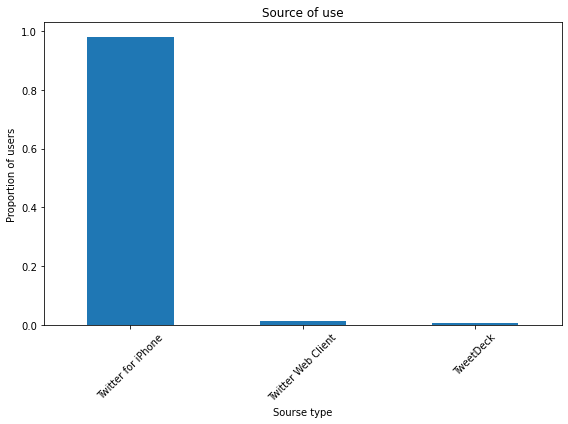

In [85]:
# Plot chart
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

plt.figure(figsize=(8,6))
df.source.value_counts(normalize=True).sort_values(ascending=False).plot.bar()
plt.title("Source of use")
plt.xticks(rotation=45)
plt.xlabel("Sourse type")
plt.ylabel("Proportion of users");

#save pic
plt.savefig('sourse.png')

### Which is the most popular dog stage?

#### Insights 2: the most popular dog stage is puper (66%)

In [86]:
df.dog_type.value_counts(normalize=True)

pupper            0.663399
doggo             0.205882
puppo             0.071895
doggo, pupper     0.029412
floofer           0.022876
doggo, puppo      0.003268
doggo, floofer    0.003268
Name: dog_type, dtype: float64

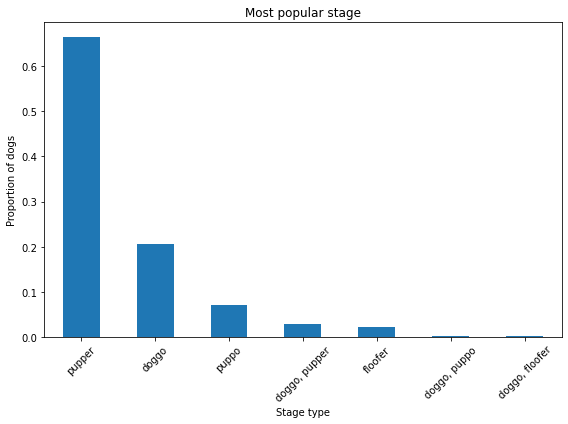

In [87]:
# Plot chart
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

plt.figure(figsize=(8,6))
df.dog_type.value_counts(normalize=True).sort_values(ascending=False).plot.bar()
plt.title("Most popular stage")
plt.xticks(rotation=45)
plt.xlabel("Stage type")
plt.ylabel("Proportion of dogs");

#save pic
plt.savefig('dog_stage.png')

### What are the most popular 10 names for the dogs?

#### Insights 3: the most popular name is Charlie

In [88]:
df.name.value_counts()

Charlie       11
Cooper        10
Lucy          10
Oliver        10
Penny          9
              ..
Leela          1
Glenn          1
Shelby         1
Sephie         1
Christoper     1
Name: name, Length: 913, dtype: int64

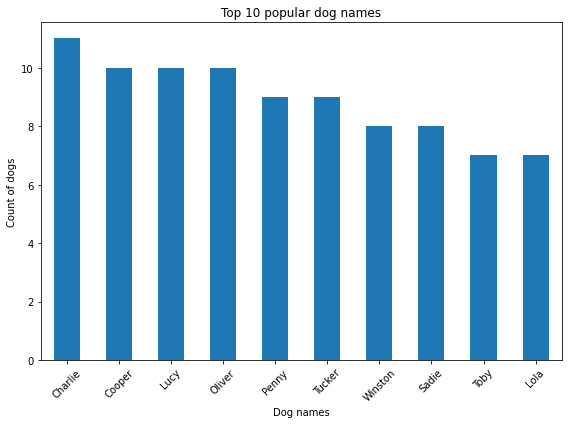

In [89]:
# Plot chart
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

plt.figure(figsize=(8,6))
df.name.value_counts()[0:10].sort_values(ascending=False).plot.bar()
plt.title("Top 10 popular dog names")
plt.xticks(rotation=45)
plt.xlabel("Dog names")
plt.ylabel("Count of dogs");

#save pic
plt.savefig('dog_names.png')

### Visualization

#### How accurate are the models predicting?

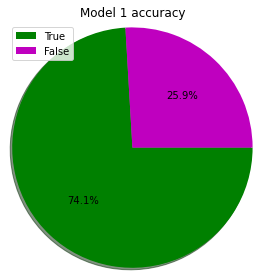

In [90]:
# Plot pie chart for model 1
labels = ['True', 'False']
values = df.p1_dog.value_counts(normalize=True)
colors = ['g','m',]
explode = (0.2, 0, 0, 0, 0)

plt.pie(values, colors=colors, autopct='%1.1f%%', radius = 1.2, shadow=True, counterclock=False)
plt.legend(labels, loc=0)
plt.title('Model 1 accuracy')
plt.tight_layout();

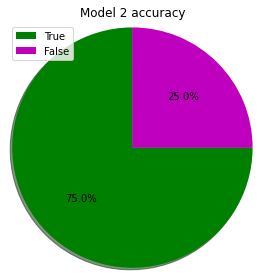

In [91]:
# Plot pie chart for model 2
labels = ['True', 'False']
values = df.p2_dog.value_counts(normalize=True)
colors = ['g','m',]
explode = (0.2, 0, 0, 0, 0)

plt.pie(values, colors=colors, autopct='%1.1f%%', radius = 1.2, shadow=True, counterclock=False)
plt.legend(labels, loc=0)
plt.title('Model 2 accuracy')
plt.tight_layout();

plt.savefig('model_forecast')

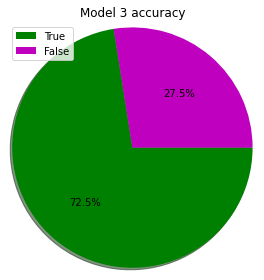

In [92]:
# Plot pie chart for model 3
labels = ['True', 'False']
values = df.p3_dog.value_counts(normalize=True)
colors = ['g','m',]
explode = (0.2, 0, 0, 0, 0)

plt.pie(values, colors=colors, autopct='%1.1f%%', radius = 1.2, shadow=True, counterclock=False)
plt.legend(labels, loc=0)
plt.title('Model 3 accuracy')
plt.tight_layout();

#### There is a strong positiv corelation between Favorite and Retweet counts. 

C:\Users\manuk\anaconda3\lib\site-packages\seaborn\regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


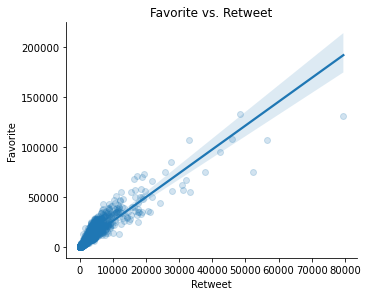

In [94]:
# Plot scatterplot of retweet vs favorite count
sns.lmplot(x="retweets", 
           y="favorites", 
           data=df,
           size = 4,
           aspect=1.3,
           scatter_kws={'alpha':1/5})
plt.title('Favorite vs. Retweet')
plt.xlabel('Retweet')
plt.ylabel('Favorite');

#save pic
plt.savefig('favorite_retweet')